# Analyzing Degree in Time-resolved networks

We want to look at how the degrees of different concepts in the network change with time.

In [1]:
import os
import sys
sys.path.append('../../../hetnet-ml/src')

import time
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import logit
from tqdm import tqdm

import graph_tools as gt
from extractor import MatrixFormattedGraph
import plot_tools as pt

DATA_DIR='../../data/'

paper_figs = os.path.join(DATA_DIR, 'figures/paper_figs')
supp_figs = os.path.join(DATA_DIR, 'figures/supp_figs')
other_figs = os.path.join(DATA_DIR, 'figures/other_figs')

In [2]:
from collections import defaultdict

In [3]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

In [4]:
def calc_percentile(df, calc_col):
    """
    Quick calculation of percentile as sorted_order / total_numb_of_obs
    """
    
    total = len(df)
    
    order = (df.sort_values(calc_col)  # sort
                .reset_index()                 # reset index to get sorterd order
                .reset_index()                 # Turn sorted index into new column
                .rename(columns={'level_0':'order'})  # Rename new sorted index column column 'order'
                .set_index('index')            # Reset the old index
                .sort_index())['order']        # sort by original index nad return order
    order.index = order.index.rename(None)     # Remove new name of index

    return ((order+1) / total)*100

In [5]:
def weighted_std(values, weights, axis=None):
    average = np.average(values, weights=weights, axis=axis)
    variance = np.average((values-average)**2, weights=weights, axis=axis)
    return np.sqrt(variance)

In [6]:
def skip_ticks(tick_delta=2, angle=0):
    locs, labels = plt.xticks(rotation=angle)
    plt.xticks(locs[::tick_delta], labels[::tick_delta])

In [7]:
def get_year_category(diff):
    if diff > 20:
        return '21+ After'
    elif diff > 15 and diff <= 20:
        return '16-20 After'
    elif diff > 10 and diff <= 15:
        return '11-15 After'
    elif diff > 5 and diff <= 10:
        return '6-10 After'
    elif diff > 0 and diff <= 5:
        return '1-5 After'
    elif diff >= -5 and diff < 0:
        return '0-5 Before'
    elif diff >= -10 and diff < -5:
        return '6-10 Before'
    elif diff >= -15 and diff < -10:
        return '11-15 Before'
    elif diff >= -20 and diff < -15:
        return '16-20 Before'
    elif diff < -20:
        return '21+ Before'

In [8]:
base_dir = os.path.join(DATA_DIR, 'time_networks-6_metanode/')
max_indication_network_diff = 0
alpha = .1
scoring = 'recall'
negative_multiplier = 10
min_pmids = 2
gs_treat = False
w=0.6
                                                                                         
test_params = os.path.join('alpha_{}'.format(alpha), '{}x_pos-neg'.format(negative_multiplier), '{}_year_diff'.format(max_indication_network_diff))

if scoring != 'roc_auc':                                                                                                
    test_params = os.path.join(test_params, '{}-scoring'.format(scoring))                                               

if min_pmids > 1:                                                                                                       
    test_params = os.path.join(test_params, '{}_pmids'.format(min_pmids))                                               

if gs_treat:                                                                                                            
    test_params = os.path.join(test_params, 'gs_treats')                                                                

if w != 0.4:
    test_params = os.path.join(test_params, 'dwpc_w_{}'.format(w))
    

In [9]:
final_nodes = gt.remove_colons(pd.read_csv(os.path.join(base_dir, '2020', test_params, 'nodes_neo4j.csv')))
id_to_kind = final_nodes.set_index('id')['label'].to_dict()

In [10]:
def get_degree_data(year):

    n = pd.read_csv(os.path.join(base_dir, str(year), test_params, 'nodes_neo4j.csv'))
    e = pd.read_csv(os.path.join(base_dir, str(year), test_params, 'edges_neo4j.csv'))

    n = gt.remove_colons(n)
    e = gt.remove_colons(e)
    
    degree_data = pd.DataFrame(index=n['id'].unique())

    for et in e['type'].unique():
        q_res = e.query('type == @et')
        e_degree = pd.concat([q_res['start_id'], q_res['end_id']]).value_counts()
        degree_data['deg_{}'.format(et)] = e_degree
       
    degree_data = degree_data.fillna(0)
    degree_data['total_degree'] = degree_data.sum(axis=1)
    
    degree_data = degree_data.reset_index().rename(columns={'index': 'node_id'})
    degree_data['node_type'] = degree_data['node_id'].map(lambda i: id_to_kind[i])
    
    
    return degree_data

In [11]:
preds = []
degrees = {}
years = list(range(1950, 2020, 1))

for year in years:
    out_dir = os.path.join(base_dir, str(year), test_params)
    pred = pd.read_csv(os.path.join(out_dir, 'predictions.csv'))
    pred['predictile'] = calc_percentile(pred, 'all_probas')
    pred['network_year'] = str(year)
    preds.append(pred)
    degrees[year] = get_degree_data(year)

In [12]:
preds = pd.concat(preds)

In [13]:
preds.head()

,cd_id,cd_name,do_id,do_name,status,approval_year,year_diff,year_cat,dataset,test_probas,all_probas,cd_percentile,do_percentile,predictile,network_year
0,D005998,Glycine,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.008610,0.379167,0.006452,9.502688,1950
1,D010837,Vitamin K 1,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.008630,0.341667,0.012903,9.553763,1950
2,D004958,Estradiol,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,train,NaN,0.008882,0.920833,0.019355,10.037634,1950
3,D002119,Calcium Carbonate,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.010092,0.637500,0.025806,11.978495,1950
4,D019342,Acetic Acid,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.010843,0.783333,0.032258,13.529570,1950


In [14]:
degrees[1950].head(2)

,node_id,deg_AFFECTS_CDafA,deg_AFFECTS_CDafPH,deg_AFFECTS_GafA,deg_AFFECTS_GafPS,deg_AFFECTS_PHafDO,deg_AFFECTS_PHafG,deg_AFFECTS_PHafPS,deg_AFFECTS_PSafDO,deg_AFFECTS_PSafPS,...,deg_LOCATION_OF_AloDO,deg_LOCATION_OF_AloG,deg_LOCATION_OF_AloPS,deg_REGULATES_CDreg>CD,deg_REGULATES_Greg>G,deg_RELATED_TO_CDrtCD,deg_STIMULATES_CDstG,deg_TREATS_CDtDO,total_degree,node_type
0,C0229664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Anatomy
1,D017776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Anatomy


In [15]:
preds['network_year'].nunique()

70

# Look at Network Degree vs Time

In [16]:
node_types = degrees[2015]['node_type'].value_counts().index
edge_types = [c for c in degrees[2015].columns if c.startswith('deg_')]

In [17]:
degrees[2015]['node_type'].value_counts()

Chemicals & Drugs              32939
Disorders                      18381
Genes & Molecular Sequences    12621
Anatomy                         9358
Physiology                      3970
Phenomena                        627
Name: node_type, dtype: int64

In [18]:
test_data = get_degree_data(2020)

In [19]:
test_data['node_type'].value_counts()

Chemicals & Drugs              33053
Disorders                      18470
Genes & Molecular Sequences    12860
Anatomy                         9396
Physiology                      3989
Phenomena                        632
Name: node_type, dtype: int64

In [20]:
edge_to_node_types = defaultdict(set)
node_to_edge_types = {}

test_df = degrees[2015]

for nt in node_types:
    res = test_df.query('node_type == @nt')[edge_types].sum() > .0001
    res = res[res].index.tolist()
    
    for et in res:
        edge_to_node_types[et].add(nt)
    node_to_edge_types[nt] = res
    

In [21]:
# Average Compound degree
nt = 'Chemicals & Drugs'
degrees[1950][node_to_edge_types[nt]].sum(axis=1).mean()

2.154696132596685

In [22]:
# Average CDtDO degree
et = 'deg_TREATS_CDtDO'
nt_to_query = edge_to_node_types[et]
degrees[1950].query('node_type in @nt_to_query')[et].mean()

1.0800582241630277

In [23]:
all_avg_degree_data = defaultdict(list)

for year, df in degrees.items():
    
    all_avg_degree_data['year'].append(year)
    all_avg_degree_data['avg'].append(df['total_degree'].mean())
    all_avg_degree_data['type'].append('total')
    all_avg_degree_data['subtype'].append('total')
    
    
    for nt in node_types:
    
        # Average node-type degree
        avg = df[node_to_edge_types[nt]].sum(axis=1).mean()
        
        all_avg_degree_data['year'].append(year)
        all_avg_degree_data['avg'].append(avg)
        all_avg_degree_data['type'].append('node')
        all_avg_degree_data['subtype'].append(nt)
        
    
    for et in edge_types:
        
        # Average CDtDO degree
        nt_to_query = edge_to_node_types[et]
        avg = df.query('node_type in @nt_to_query')[et].mean()
        
        all_avg_degree_data['year'].append(year)
        all_avg_degree_data['avg'].append(avg)
        all_avg_degree_data['type'].append('edge')
        all_avg_degree_data['subtype'].append(et[4:])
        
all_avg_degree_data = pd.DataFrame(all_avg_degree_data).reset_index(drop=True)

In [24]:
all_avg_degree_data.head(3)

,avg,subtype,type,year
0,7.282689,total,total,1950
1,2.154696,Chemicals & Drugs,node,1950
2,4.798343,Disorders,node,1950


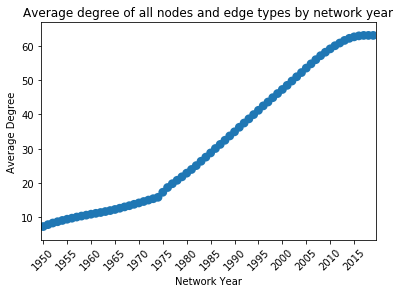

In [25]:
sns.pointplot(x='year', y='avg', data=all_avg_degree_data.query('type == "total"'), color=sns.color_palette()[0])
plt.title('Average degree of all nodes and edge types by network year')
plt.xlabel('Network Year')
plt.ylabel('Average Degree')
skip_ticks(5, 45);

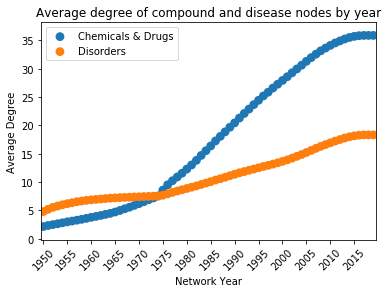

In [26]:
data = all_avg_degree_data.query('type == "node" and subtype in {}'.format(['Chemicals & Drugs', 'Disorders']))

sns.pointplot(x='year', y='avg', data=data, hue='subtype')
plt.title('Average degree of compound and disease nodes by year')
plt.xlabel('Network Year')
plt.ylabel('Average Degree')

skip_ticks(5, 45);
plt.legend(title='');


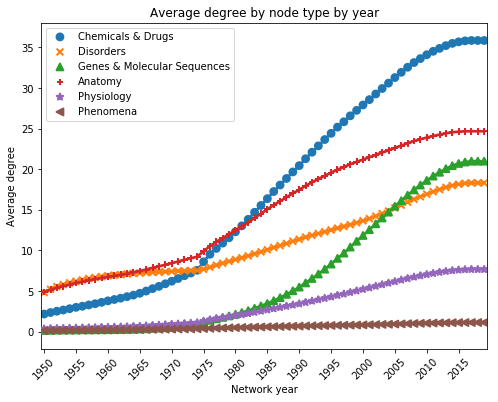

In [27]:
data = all_avg_degree_data.query('type == "node"')

markers = ['o', 'x', '^', '+', '*', '<', 's', 'p', 'D', 'V'][:data['subtype'].nunique()]


fig, ax = plt.subplots(1, 1)
fig.set_size_inches((8, 6))

sns.pointplot(x='year', y='avg', data=data, hue='subtype', markers=markers)
plt.title('Average degree by node type by year')
plt.xlabel('Network year')
plt.ylabel('Average degree')

skip_ticks(5, 45);

plt.legend(title='')

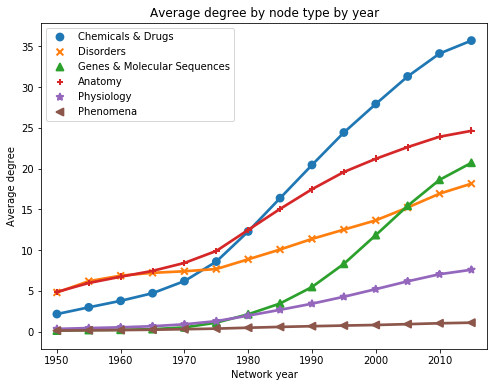

In [28]:
data = all_avg_degree_data.query('type == "node"')
data = data.query('year in {}'.format(list(range(1950,2025, 5))))

markers = ['o', 'x', '^', '+', '*', '<', 's', 'p', 'D', 'V'][:data['subtype'].nunique()]


fig, ax = plt.subplots(1, 1)
fig.set_size_inches((8, 6))

sns.pointplot(x='year', y='avg', data=data, hue='subtype', markers=markers)
plt.title('Average degree by node type by year')
plt.xlabel('Network year')
plt.ylabel('Average degree')

skip_ticks(2, 0);

plt.legend(title='')
plt.savefig(os.path.join(paper_figs, '2B.svg'), bbox_inches='tight', pad_inches=0.1);

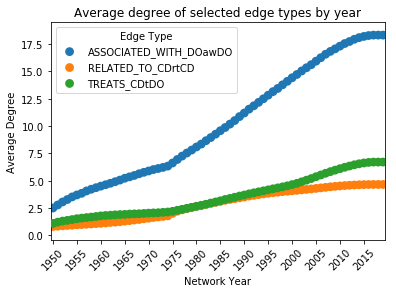

In [29]:
q_edges = ['ASSOCIATED_WITH_DOawDO', 'TREATS_CDtDO', 'RELATED_TO_CDrtCD']
data = all_avg_degree_data.query('type == "edge" and subtype in {}'.format(q_edges))

sns.pointplot(x='year', y='avg', data=data, hue='subtype')
plt.title('Average degree of selected edge types by year')
plt.xlabel('Network Year')
plt.ylabel('Average Degree')

skip_ticks(5, 45);

plt.legend(title='Edge Type');

# Look Degrees for relative years...

For each network, we can look at a given compound-disease indication and see when the compound was approved relative to the year of the network.  If the compound was approved long before the network, we'd expect that compound and that disease to have higher degree (there to be more known about it) than if it was approved long after the year of the network...

First start by grouping compounds by the years they were approved (or diseases by the year in which their first treatment was approved)

In [30]:
examples_strat = pd.DataFrame(index=preds['network_year'].unique())
deg_prepped = defaultdict(pd.DataFrame)

for i, diff, in enumerate(range(-30, 31)):
    pos_ex = preds.query('year_diff == @diff and status == 1 and network_year != "2020"') # 2020 is only past, so ignore
    
    for yr in pos_ex['network_year'].unique():
        q_res = pos_ex.query('network_year == @yr')
        comps = q_res['cd_id'].unique()
        diss = q_res['do_id'].unique()
        
        pos_comp_dis = np.concatenate((comps, diss))
        pos_degrees = degrees[int(yr)].query('node_id in @pos_comp_dis').copy()
        pos_degrees['network_year'] = int(yr)
        
        deg_prepped[diff] = pd.concat([deg_prepped[diff], pos_degrees])

In [31]:
deg_prepped[-30].head(2)

,node_id,deg_AFFECTS_CDafA,deg_AFFECTS_CDafPH,deg_AFFECTS_GafA,deg_AFFECTS_GafPS,deg_AFFECTS_PHafDO,deg_AFFECTS_PHafG,deg_AFFECTS_PHafPS,deg_AFFECTS_PSafDO,deg_AFFECTS_PSafPS,...,deg_LOCATION_OF_AloG,deg_LOCATION_OF_AloPS,deg_REGULATES_CDreg>CD,deg_REGULATES_Greg>G,deg_RELATED_TO_CDrtCD,deg_STIMULATES_CDstG,deg_TREATS_CDtDO,total_degree,node_type,network_year
3032,D006051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,Chemicals & Drugs,1957
5984,DOID:7148,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,66.0,177.0,Disorders,1957


In [32]:
deg_prepped = {k: (v.sort_values('network_year')
                    .drop_duplicates(subset=['node_id'], keep='first')
                    .reset_index(drop=True)) for k, v in deg_prepped.items()}

In [33]:
examples_strat = {k: v['network_year'].value_counts().sort_index() for k, v in deg_prepped.items()}

In [34]:
examples_strat = (pd.melt(pd.DataFrame(examples_strat).reset_index(), 
                         id_vars=['index'], value_vars=[i for i in range(-30, 31)])
                    .rename(columns={'index': 'network_year', 'variable': 'diff', 'value': 'concepts'}))

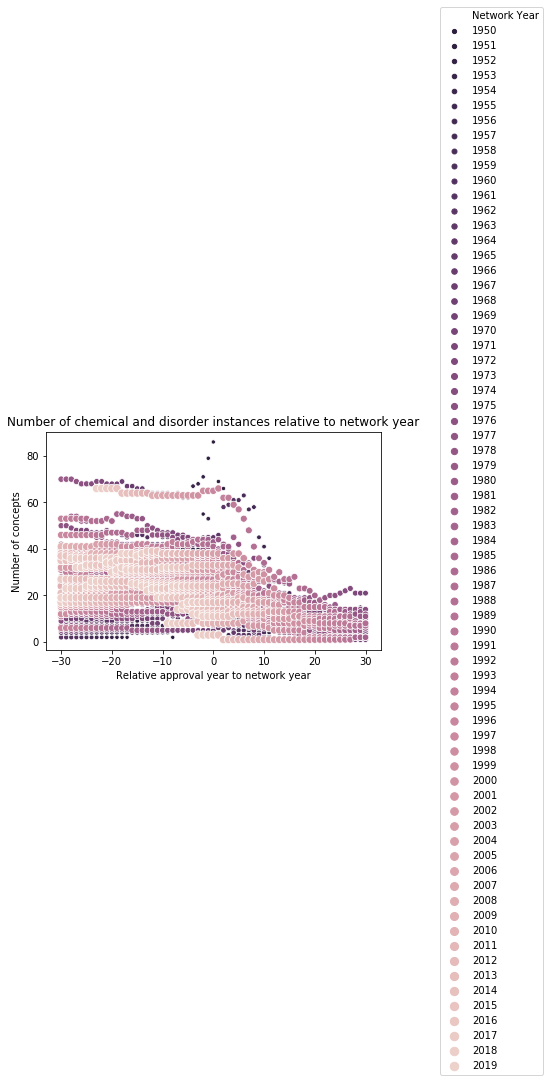

In [35]:
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)

sns.scatterplot(x='diff', y='concepts', data=examples_strat.rename(columns={'network_year': 'Network Year'}),
                hue='Network Year', palette=cmap, size='Network Year', legend='full')

plt.title('Number of chemical and disorder instances relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Number of concepts')
plt.legend(loc='right', bbox_to_anchor=(1.5, .5));

In [36]:
def get_avg_deg(data, node_types=None, edge_types=None):
    
    avg_deg = []
    diffs = []
    
    
    if edge_types is None:
        edge_types = ['total_degree']
    elif type(edge_types) == str:
        edge_types = [edge_types]
    
    if type(node_types) == str:
        node_types == [node_types]
    
    
    for diff, df in data.items():
        
        diffs.append(diff)
        
        if node_types is not None:
            df = df.query('node_type in @node_types')
        
        edge_degs = df[edge_types].sum(axis=1)
        avg_deg.append(edge_degs.mean())

    avg_deg = pd.DataFrame({'diff': diffs, 'avg_deg': avg_deg}).sort_values('diff')
    return avg_deg

In [37]:
counts = {'diff': [], 'node_type': [], 'count': []}

for diff, df in deg_prepped.items():

    for nt in ['Chemicals & Drugs', 'Disorders']:
    
        counts['diff'].append(diff)
        counts['node_type'].append(nt)
        res = df.query('node_type == @nt')
        counts['count'].append(len(res))
    

counts = pd.DataFrame(counts)


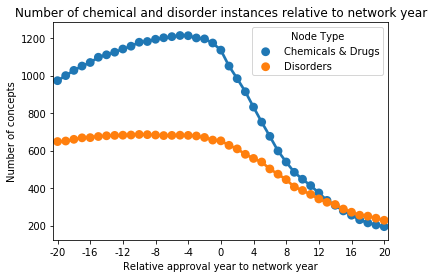

In [38]:
sns.pointplot(x='diff', y='count', data=counts.query("diff >= -20 and diff <= 20"), hue='node_type')
plt.title('Number of chemical and disorder instances relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Number of concepts')
test = plt.legend(title='Node Type')
locs, labels = plt.xticks()
tick_delta = 4
plt.xticks(locs[::tick_delta], labels[::tick_delta]);

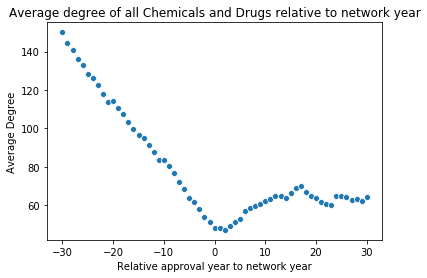

In [39]:
avg_deg = get_avg_deg(deg_prepped)
sns.scatterplot(x='diff', y='avg_deg', data=avg_deg)
plt.title('Average degree of all Chemicals and Drugs relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');

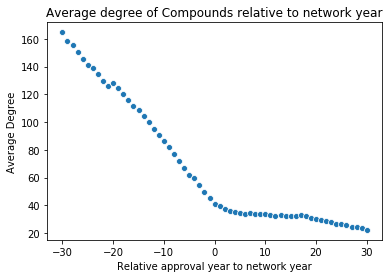

In [40]:
avg_comp_deg = get_avg_deg(deg_prepped, node_types='Chemicals & Drugs')
sns.scatterplot(x='diff', y='avg_deg', data=avg_comp_deg)
plt.title('Average degree of Compounds relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');

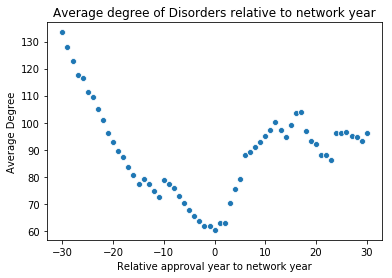

In [41]:
avg_dis_deg = get_avg_deg(deg_prepped, node_types='Disorders')
sns.scatterplot(x='diff', y='avg_deg', data=avg_dis_deg)
plt.title('Average degree of Disorders relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');

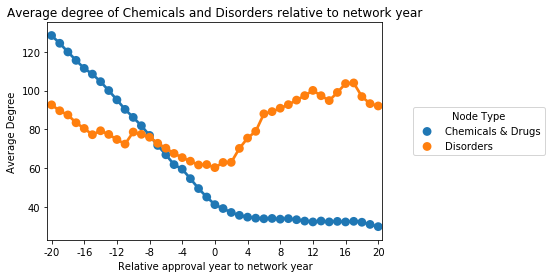

In [42]:
avg_comp_deg['node_type'] = 'Chemicals & Drugs'
avg_dis_deg['node_type'] = 'Disorders'

avg_mn_deg = pd.concat([avg_comp_deg, avg_dis_deg])

sns.pointplot('diff', 'avg_deg', data=avg_mn_deg.query('diff >= -20 and diff <= 20'), hue='node_type')
plt.title('Average degree of Chemicals and Disorders relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Node Type', loc='right', bbox_to_anchor=(1.5, .5));

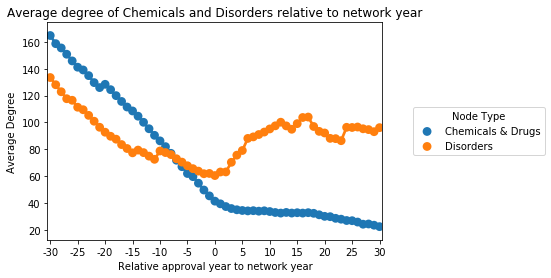

In [43]:
sns.pointplot('diff', 'avg_deg', data=avg_mn_deg, hue='node_type')
plt.title('Average degree of Chemicals and Disorders relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 5
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Node Type', loc='right', bbox_to_anchor=(1.5, .5));

In [44]:
ind_et_avgs = []
for nt in node_types:
    for et in edge_types:
        cur_avg = get_avg_deg(deg_prepped, node_types=nt, edge_types=et).fillna(0)
        if sum(cur_avg['avg_deg']) < .0001:
            continue
            
        cur_avg['edge_type'] = et[4:]
        cur_avg['node_type'] = nt
        
        ind_et_avgs.append(cur_avg)
ind_et_avgs = pd.concat(ind_et_avgs)

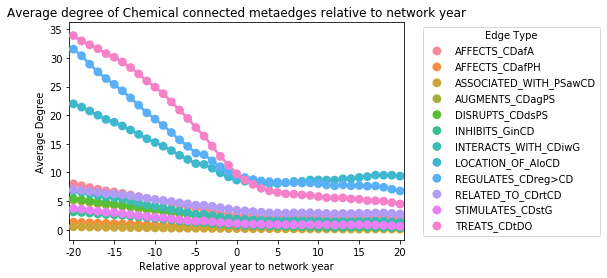

In [45]:
data = ind_et_avgs.query('node_type == "Chemicals & Drugs" and diff >= -20 and diff <= 20')

sns.pointplot('diff', 'avg_deg', data=data, hue='edge_type')
plt.title('Average degree of Chemical connected metaedges relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 5
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Edge Type', loc='right', bbox_to_anchor=(1.6, .5));

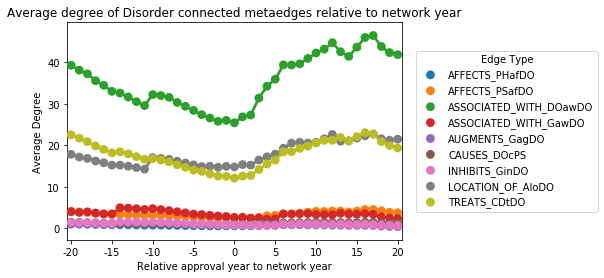

In [46]:
data = ind_et_avgs.query('node_type == "Disorders" and diff >= -20 and diff <= 20')

sns.pointplot('diff', 'avg_deg', data=data, hue='edge_type')
plt.title('Average degree of Disorder connected metaedges relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 5
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Edge Type', loc='right', bbox_to_anchor=(1.6, .5));

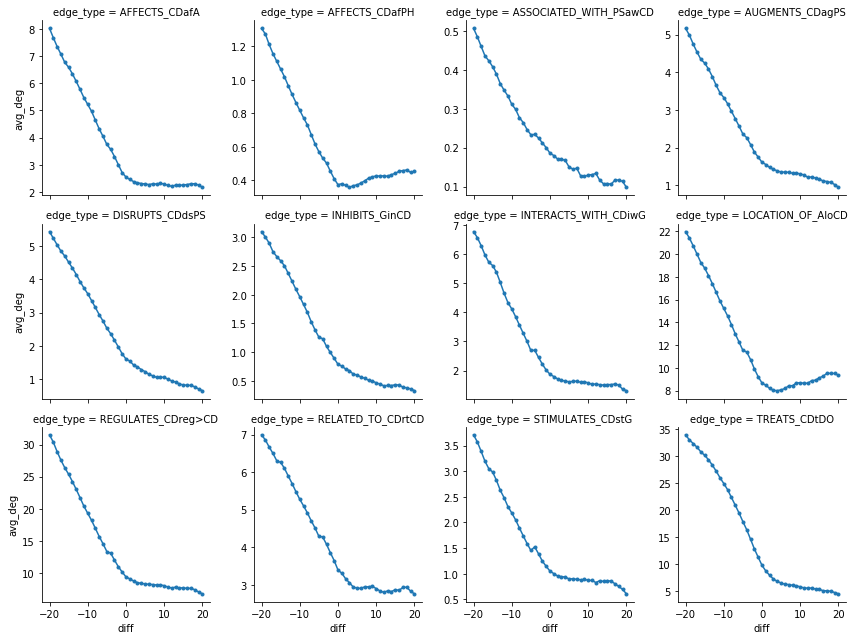

In [47]:
qres = ind_et_avgs.query('node_type == "Chemicals & Drugs" and diff <= 20 and diff >= -20')
g = sns.FacetGrid(qres, col='edge_type', col_wrap=4, sharey=False)
g.map(plt.plot, 'diff', 'avg_deg', marker='.');

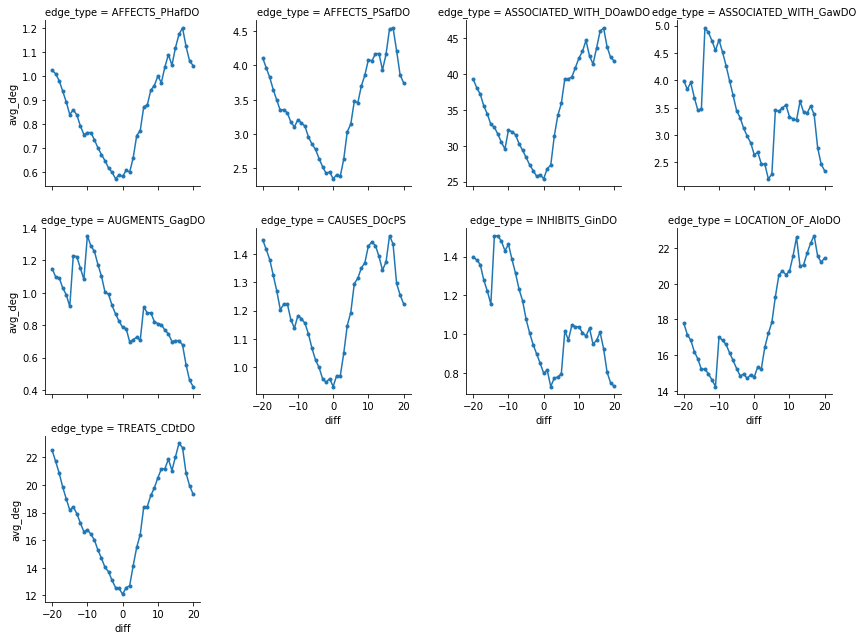

In [48]:
qres = ind_et_avgs.query('node_type == "Disorders" and diff <= 20 and diff >= -20')
g = sns.FacetGrid(qres, col='edge_type', col_wrap=4, sharey=False)
g.map(plt.plot, 'diff', 'avg_deg', marker='.');

# Is there some kind of outlier effect causing these repetitive patterns?

In [49]:
diff = 20
nt = "Chemicals & Drugs"

result_df = get_avg_deg(deg_prepped, node_types=nt)
diff_avg = result_df.set_index('diff').loc[diff, 'avg_deg']

deg_prepped[diff].query('node_type == @nt and total_degree > @diff_avg')[['node_id', 'total_degree']]


,node_id,total_degree
27,D013739,37.0
57,D004958,31.0
70,C003549,40.0
71,D005998,31.0
116,D019343,41.0
117,D007328,132.0
137,D019344,101.0
149,D003545,49.0
163,D000241,47.0
194,D061485,98.0


### MeSH: C570710

https://meshb.nlm.nih.gov/record/ui?ui=C570710

    MeSH Supplementary asfotase alfa 
    
    Unique ID
        C570710
    
    Entry Term(s)
        ENB-0040
        Strensiq 
    
    Registry Number
        Z633861EIM
    
    Heading Mapped to
        *Alkaline Phosphatase
        *Immunoglobulin G
        *Recombinant Fusion Proteins
        
    Frequency
        15
    Note
        comprising the TNSALP ectodomain, the constant region of the human IgG1 Fc domain, and a terminal deca-aspartate motif for bone targeting
    Source
        N Engl J Med. 2012 Mar 8;366(10):904-13
    Indexing Information
        Hypophosphatasia
        Enzyme Replacement Therapy
    Date of Entry
        2012/03/15
    Revision Date
        2017/09/21

In [50]:
deg_prepped[diff].query('node_id == "C570710"').T

,407
node_id,C570710
deg_AFFECTS_CDafA,70
deg_AFFECTS_CDafPH,11
deg_AFFECTS_GafA,0
deg_AFFECTS_GafPS,0
deg_AFFECTS_PHafDO,0
deg_AFFECTS_PHafG,0
deg_AFFECTS_PHafPS,0
deg_AFFECTS_PSafDO,0
deg_AFFECTS_PSafPS,0


In [51]:
sys.path.append('../../')
from tools import smirnov_grubbs as grubbs

In [52]:
print(len(deg_prepped[20].query('node_type == @nt')))

194


In [53]:
len(grubbs.test(deg_prepped[diff].query('node_type == @nt')['total_degree'], alpha=.0001))

../../tools/smirnov_grubbs.py:153: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  index = relative_values.argmax()


186

In [54]:
removed = []
deg_prepped_no_outlier = {}

for diff, df in deg_prepped.items():

    keep_data = []
    
    for nt in ['Chemicals & Drugs', 'Disorders']:

        qres = df.query('node_type == @nt')
        if len(qres) > 0:
            bad_idx = grubbs.max_test_indices(qres['total_degree'].values, alpha=.0001)
            removed.append(qres.iloc[bad_idx].copy())
            removed[-1]['diff'] = diff
            keep_data.append(qres.drop(qres.iloc[bad_idx].index).copy())
            
            
    deg_prepped_no_outlier[diff] = pd.concat(keep_data)
removed = pd.concat(removed)

In [55]:
counts_no_outlier = {'diff': [], 'node_type': [], 'count': []}

for diff, df in deg_prepped.items():

    for nt in ['Chemicals & Drugs', 'Disorders']:
    
        counts_no_outlier['diff'].append(diff)
        counts_no_outlier['node_type'].append(nt)
        res = df.query('node_type == @nt')
        counts_no_outlier['count'].append(len(res))
    

counts_no_outlier = pd.DataFrame(counts_no_outlier)

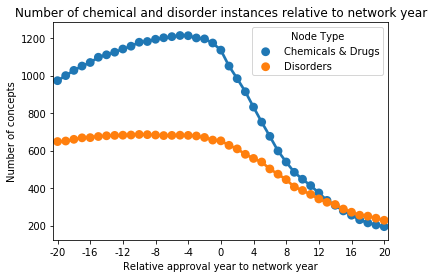

In [56]:
data = counts_no_outlier.query("diff >= -20 and diff <= 20")

sns.pointplot(x='diff', y='count', data=data, hue='node_type')
plt.title('Number of chemical and disorder instances relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Number of concepts')
test = plt.legend(title='Node Type')
locs, labels = plt.xticks()
tick_delta = 4
plt.xticks(locs[::tick_delta], labels[::tick_delta]);

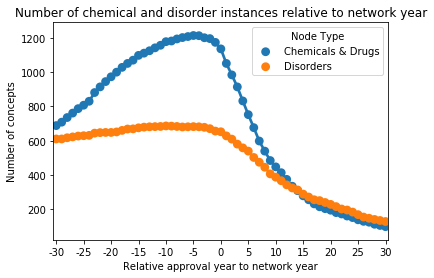

In [57]:
sns.pointplot(x='diff', y='count', data=counts_no_outlier, hue='node_type')
plt.title('Number of chemical and disorder instances relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Number of concepts')
test = plt.legend(title='Node Type')
locs, labels = plt.xticks()
tick_delta = 5
plt.xticks(locs[::tick_delta], labels[::tick_delta]);

In [58]:
avg_mn_deg_outlier = []
for nt in ['Chemicals & Drugs', 'Disorders']:
    res = get_avg_deg(deg_prepped_no_outlier, node_types=nt)
    res['node_type'] = nt
    avg_mn_deg_outlier.append(res)
avg_mn_deg_outlier = pd.concat(avg_mn_deg_outlier)

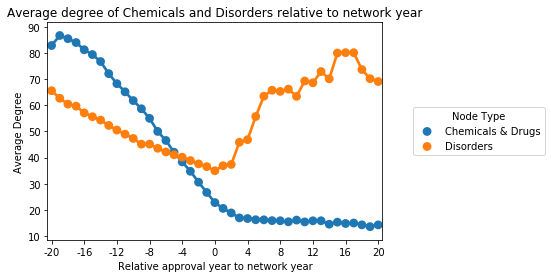

In [59]:
data = avg_mn_deg_outlier.query("diff >= -20 and diff <= 20")

sns.pointplot(x='diff', y='avg_deg', data=data, hue='node_type')
plt.title('Average degree of Chemicals and Disorders relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Node Type', loc='right', bbox_to_anchor=(1.5, .5));

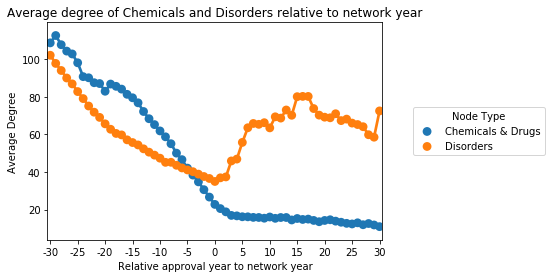

In [60]:
sns.pointplot(x='diff', y='avg_deg', data=avg_mn_deg_outlier, hue='node_type')
plt.title('Average degree of Chemicals and Disorders relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 5
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Node Type', loc='right', bbox_to_anchor=(1.5, .5));

In [61]:
ind_et_avgs_outlier = []
for nt in node_types:
    for et in edge_types:
        cur_avg = get_avg_deg(deg_prepped_no_outlier, node_types=nt, edge_types=et).fillna(0)
        if sum(cur_avg['avg_deg']) < .0001:
            continue
            
        cur_avg['edge_type'] = et[4:]
        cur_avg['node_type'] = nt
        
        ind_et_avgs_outlier.append(cur_avg)
ind_et_avgs_outlier = pd.concat(ind_et_avgs_outlier)

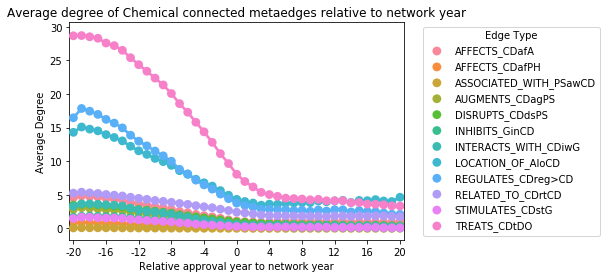

In [62]:
data = ind_et_avgs_outlier.query('node_type == "Chemicals & Drugs" and diff >= -20 and diff <= 20')

sns.pointplot('diff', 'avg_deg', data=data, hue='edge_type')
plt.title('Average degree of Chemical connected metaedges relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Edge Type', loc='right', bbox_to_anchor=(1.6, .5));

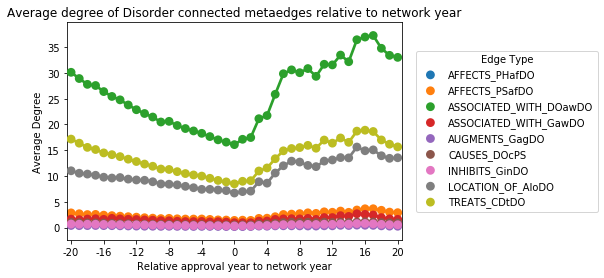

In [63]:
data = ind_et_avgs_outlier.query('node_type == "Disorders" and diff >= -20 and diff <= 20')

sns.pointplot('diff', 'avg_deg', data=data, hue='edge_type')
plt.title('Average degree of Disorder connected metaedges relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Edge Type', loc='right', bbox_to_anchor=(1.6, .5));

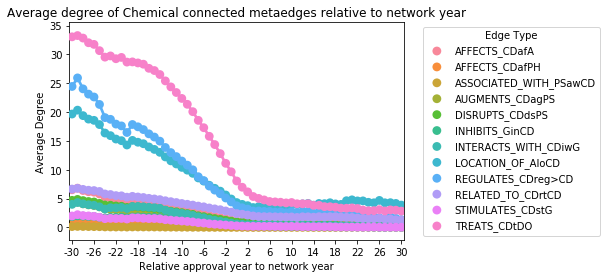

In [64]:
data = ind_et_avgs_outlier.query('node_type == "Chemicals & Drugs"')

sns.pointplot('diff', 'avg_deg', data=data, hue='edge_type')
plt.title('Average degree of Chemical connected metaedges relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Edge Type', loc='right', bbox_to_anchor=(1.6, .5));

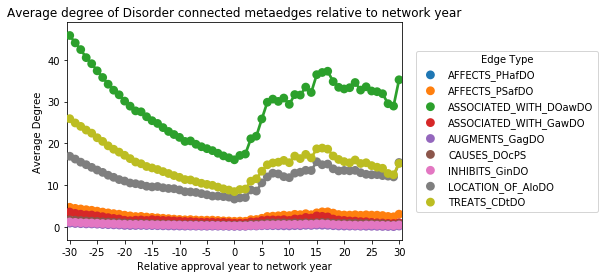

In [65]:
data = ind_et_avgs_outlier.query('node_type == "Disorders"')

sns.pointplot('diff', 'avg_deg', data=data, hue='edge_type')
plt.title('Average degree of Disorder connected metaedges relative to network year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Average Degree');locs, labels = plt.xticks()
tick_delta = 5
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta]);
plt.legend(title='Edge Type', loc='right', bbox_to_anchor=(1.6, .5));

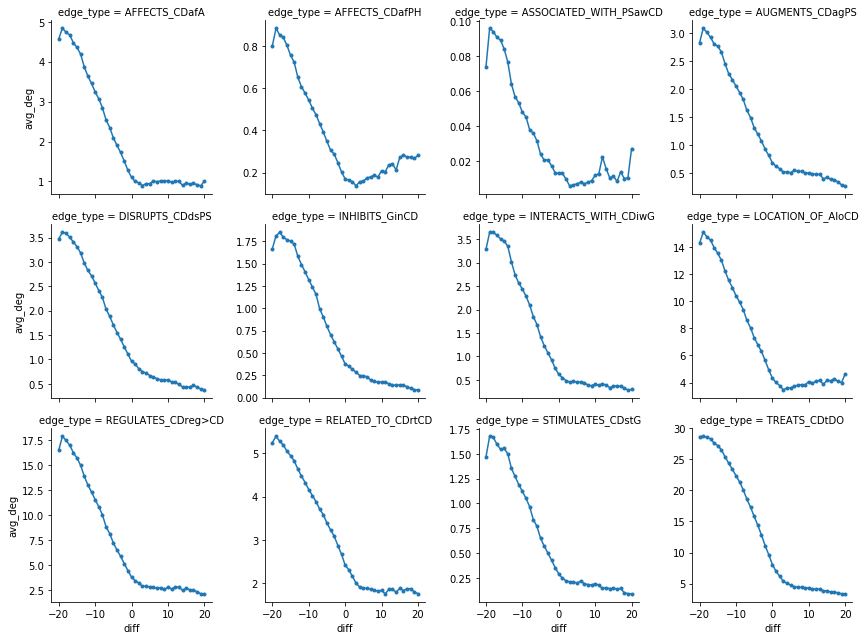

In [66]:
qres = ind_et_avgs_outlier.query('node_type == "Chemicals & Drugs" and diff <= 20 and diff >= -20')
g = sns.FacetGrid(qres, col='edge_type', col_wrap=4, sharey=False)
g.map(plt.plot, 'diff', 'avg_deg', marker='.');

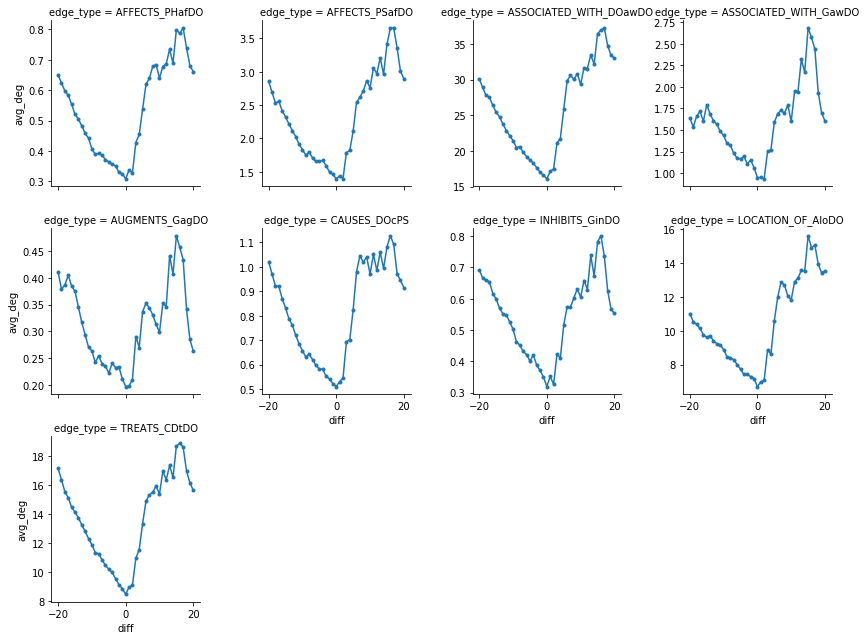

In [67]:
qres = ind_et_avgs_outlier.query('node_type == "Disorders" and diff <= 20 and diff >= -20')
g = sns.FacetGrid(qres, col='edge_type', col_wrap=4, sharey=False)
g.map(plt.plot, 'diff', 'avg_deg', marker='.');